In [1]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np

#导入数据，分类
data = pd.read_csv('data_q1.csv')
data.sort_values(by=['global_id', 'trade_date'], inplace=True)
#data['close'].fillna(method='ffill', inplace=True)

Question 1

Question1.1

In [2]:
#处理缺失值
data['close'].fillna(method='ffill', inplace=True)
data['adj_factor'].fillna(method='ffill', inplace=True)
data

,trade_date,global_id,close,adj_factor
0,20160104,1,11.33,85.994092
2841,20160105,1,11.40,85.994092
5682,20160106,1,11.53,85.994092
8525,20160107,1,10.94,85.994092
11368,20160108,1,11.12,85.994092
...,...,...,...,...
4261014,20201225,872925,31.68,1.013216
4265216,20201228,872925,31.68,1.013216
4269419,20201229,872925,31.68,1.013216
4273625,20201230,872925,31.68,1.013216


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def compute_spread(data):
    data = data.copy()
    data['adj_close'] = data['close'] * data['adj_factor']
    data['log_adj_close'] = np.log(data['adj_close'])
    data.fillna(method='ffill', inplace=True)
    # 制作一个 pivot table index是trade_date as index, columns 是global_id a 值为log_adj_close 

    pivot_data = data.pivot(index='trade_date', columns='global_id', values='log_adj_close')

    # 只需要过去250天的corr
    last_250_days = pivot_data.iloc[-250:]

    corr_matrix = last_250_days.corr()
    distance_matrix = 1 - corr_matrix
    # 对整个dataframe的每一行进行apply操作，避免了昂贵的循环操作

    def calculate_spread(row):
        current_stock_id = row['global_id']
        sorted_distance = distance_matrix[current_stock_id].nsmallest(11)
        closest_stock_ids = sorted_distance.index[1:]
        reference_price = pivot_data.loc[row['trade_date'], closest_stock_ids].mean()
        spread = row['log_adj_close'] - reference_price
        return spread

    data['spread'] = data.apply(calculate_spread, axis=1)
    data['mean_60d'] = data['spread'].rolling(window=60).mean()
    data['std_60d'] = data['spread'].rolling(window=60).std()
    data['spread'] = (data['spread'] - data['mean_60d']) / data['std_60d']

    return data

In [5]:
# spread输出，为了检查是否正确，没有忽略warning结果
data['spread'] = compute_spread(data)['spread']

In [12]:
#spread数据展示
data

,trade_date,global_id,close,adj_factor,spread
0,20160104,1,11.33,85.994092,NaN
2841,20160105,1,11.40,85.994092,NaN
5682,20160106,1,11.53,85.994092,NaN
8525,20160107,1,10.94,85.994092,NaN
11368,20160108,1,11.12,85.994092,NaN
...,...,...,...,...,...
4261014,20201225,872925,31.68,1.013216,0.860397
4265216,20201228,872925,31.68,1.013216,0.828342
4269419,20201229,872925,31.68,1.013216,0.985574
4273625,20201230,872925,31.68,1.013216,0.818529


In [16]:
#收益率加入到data
data['adj_close'] = data['close'] * data['adj_factor']
data['adj_return'] = data.groupby('global_id')['adj_close'].pct_change()
data.dropna()

,trade_date,global_id,close,adj_factor,spread,adj_close,adj_return
168329,20160401,1,10.66,85.994092,-0.092403,916.697021,0.001880
171203,20160405,1,10.70,85.994092,-0.176393,920.136784,0.003752
174077,20160406,1,10.72,85.994092,0.122904,921.856666,0.001869
176952,20160407,1,10.59,85.994092,-0.125329,910.677434,-0.012127
179827,20160408,1,10.57,85.994092,-0.180860,908.957552,-0.001889
...,...,...,...,...,...,...,...
4261014,20201225,872925,31.68,1.013216,0.860397,32.098683,0.000000
4265216,20201228,872925,31.68,1.013216,0.828342,32.098683,0.000000
4269419,20201229,872925,31.68,1.013216,0.985574,32.098683,0.000000
4273625,20201230,872925,31.68,1.013216,0.818529,32.098683,0.000000


Question 1.2

In [14]:
#使用相关系数计算
def compute_spearman_correlation(data):
    #数据排序
    data = data.sort_values(by=['trade_date'])

    #得到下月收益率
    data['next_month_return'] = data.groupby('global_id')['adj_return'].shift(-1)

    # 储存corr月度
    monthly_correlations = []

    # 确定无重复数据
    unique_dates = data['trade_date'].unique()

    for date in unique_dates:
        # 计算spread和下个月的Spearman corr
        current_data = data[data['trade_date'] == date]
        spearman_corr = current_data[['spread', 'next_month_return']].corr(method='spearman').iloc[0, 1]
        monthly_correlations.append({'trade_date': date, 'spearman_corr': spearman_corr})
    #转换成dataframe
    correlation_df = pd.DataFrame(monthly_correlations)

    return correlation_df

In [17]:
# 计算spearman:
correlation_results = compute_spearman_correlation(data)
print(correlation_results)

      trade_date  spearman_corr
0       20160104       0.031299
1       20160105      -0.069784
2       20160106       0.040522
3       20160107       0.076044
4       20160108       0.105566
...          ...            ...
1213    20201225      -0.015080
1214    20201228      -0.045472
1215    20201229      -0.066486
1216    20201230      -0.141603
1217    20201231            NaN

[1218 rows x 2 columns]


In [27]:
#ic系数均值，为-0.051绝对值>0.05,是有效的因子，与收益率成反比
correlation_results['spearman_corr'].mean()

-0.05106397902081324

In [20]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

#确保trade_date是datetime对象
correlation_results['trade_date'] = pd.to_datetime(correlation_results['trade_date'], format='%Y%m%d')
# 设置trade_date为DataFrame的索引
correlation_results.set_index('trade_date', inplace=True)
# 将数据重新采样为日数据
daily_data = correlation_results.resample('D').asfreq()
daily_data['spearman_corr'] = daily_data['spearman_corr'].interpolate(method='nearest')


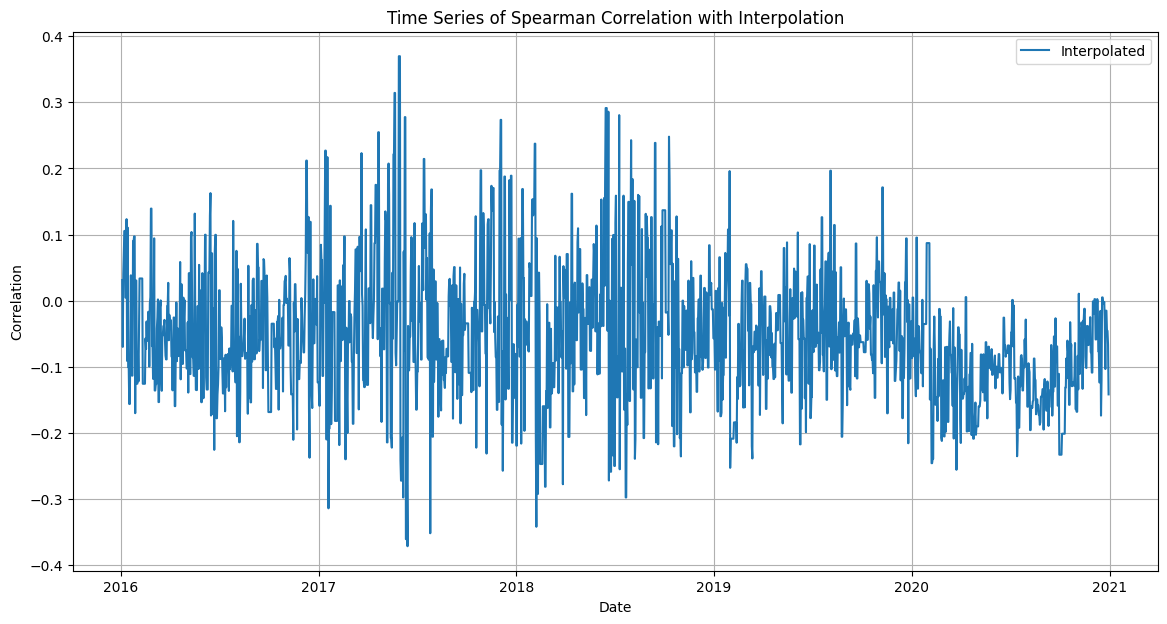

ADF Statistic: -6.579338515782156
p-value: 7.583400383578861e-09
Critical Values: {'1%': -3.433978046594855, '5%': -2.8631425806072164, '10%': -2.567623161347749}
The time series is stationary.


In [21]:
# 可视化填充后的数据
plt.figure(figsize=(14, 7))
plt.plot(daily_data.index, daily_data['spearman_corr'], label='Interpolated')
plt.title('Time Series of Spearman Correlation with Interpolation')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

# 执行ADF测试
result = adfuller(daily_data['spearman_corr'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

时间序列为平稳，拒绝有单位根的原假设